In [87]:
import sys
# setting path
sys.path.append('..')

In [88]:
import numpy as np

from src import inout, var, utils, fourier, lin_reg, reconstruction
from vis import plotter

import importlib
importlib.reload(io)
importlib.reload(var)
importlib.reload(utils)
importlib.reload(fourier)
importlib.reload(lin_reg)
importlib.reload(reconstruction)

importlib.reload(plotter)

<module 'vis.plotter' from '/home/ray/git-projects/spec_appx/notebooks/../vis/plotter.py'>

In [20]:
grid = var.grid()
cell = var.topo_cell()
    
reader = inout.ncdata()
fn = '../data/icon_grid_0012_R02B04_G_linked.nc'
reader.read_dat(fn, grid)
grid.apply_f(utils.rad2deg)

lat_ref = 43
lon_ref = 42
vid = utils.pick_cell(lat_ref, lon_ref, grid)

lat_v = grid.clat_vertices[vid,:]
lon_v = grid.clon_vertices[vid,:]

Nx, Ny = 480, 480

cell.lat = np.linspace(lat_v.min(), lat_v.max(), Nx)
cell.lon = np.linspace(lon_v.min(), lon_v.max(), Ny)

cell.gen_mgrids()
cell.topo = np.cos(cell.lon_grid)

# define triangle given the vertices
triangle = utils.triangle(lon_v, lat_v)
cell.get_masked(triangle)

In [132]:
grid = var.grid()
cell = var.topo_cell()

vid = utils.isoceles(grid, cell)

lat_v = grid.clat_vertices[vid,:]
lon_v = grid.clon_vertices[vid,:]

cell.gen_mgrids()
cell.topo = np.sin( -5.0 * cell.lat_grid + 11.0 * cell.lon_grid)

# define triangle given the vertices
triangle = utils.triangle(lon_v, lat_v)
cell.get_masked(triangle)

In [211]:
def get_opt_alpha(rng, errs = None):
    for ii, lmbda in enumerate(rng):
        a_m, data_recons = lin_reg.do(fobj, cell, lmbda = lmbda)

        fobj.get_freq_grid(a_m)
        freqs = 2.0 * np.abs(fobj.ampls)
        max_frq = freqs.max()

        print(ii, lmbda, max_frq)

        if errs is not None:
            errs[ii] = np.abs(max_frq - 1.0)
            
        return errs

In [212]:
nhi = 12
nhj = 12

fobj = fourier.f_trans(nhi,nhj)
fobj.do_full(cell)

cl_range = np.arange(1,11) / 10.0
cl_errs = np.zeros_like(cl_range)

get_opt_alpha(cl_range,cl_errs)
# for ii, coarse_lmbda in enumerate(cl_range):
#     a_m, data_recons = lin_reg.do(fobj, cell, lmbda = coarse_lmbda)

#     fobj.get_freq_grid(a_m)
#     freqs = 2.0 * np.abs(fobj.ampls)
#     max_frq = freqs.max()
    
#     print(ii, coarse_lmbda, max_frq)
    
#     cl_errs[ii] = np.abs(max_frq - 1.0)
    
print("")

fl_range = np.linspace(min_cl-0.09, min_cl+0.09, 19)
fl_errs = np.zeros_like(fl_range)

for ii, fine_lmbda in enumerate(fl_range):
    fine_lmbda = np.around(fine_lmbda,2)
    a_m, data_recons = lin_reg.do(fobj, cell, lmbda = fine_lmbda)

    fobj.get_freq_grid(a_m)
    freqs = 2.0 * np.abs(fobj.ampls)
    max_frq = freqs.max()
    
    print(ii, fine_lmbda, max_frq)
    
    fl_errs[ii] = np.abs(max_frq - 1.0)
    
print("")

min_cl = cl_range[np.argmin(cl_errs)]
min_fl = fl_range[np.argmin(fl_errs)]

min_err_cl = cl_errs[np.argmin(cl_errs)]
min_err_fl = fl_errs[np.argmin(fl_errs)]

##### !!! REDO RECONS FOR OPTIMAL ALPHA

dat_2D = reconstruction.recon_2D(data_recons, cell)
err_dat = np.linalg.norm(dat_2D - cell.topo)

print(err_dat)

0 0.1 1.5952210567176364
1 0.2 1.4342810083817938
2 0.3 1.3145945675860764
3 0.4 1.218391390848739
4 0.5 1.1379822343078152
5 0.6 1.069120181642097
6 0.7 1.009137014859244
7 0.8 0.9562173658938016
8 0.9 0.9090575633132594
9 1.0 0.866684121502941

0 0.61 1.0627574564403421
1 0.62 1.05648076304708
2 0.63 1.0502880880617482
3 0.64 1.0441774900868528
4 0.65 1.0381470961351051
5 0.66 1.0321950982689898
6 0.67 1.026319750454386
7 0.68 1.0205193656114577
8 0.69 1.014792312847692
9 0.7 1.009137014859244
10 0.71 1.0035519454880513
11 0.72 0.9980356274232122
12 0.73 0.9925866300362113
13 0.74 0.9872035673403732
14 0.75 0.9818850960658203
15 0.76 0.9766299138418869
16 0.77 0.9714367574795948
17 0.78 0.966304401347464
18 0.79 0.9612316558343785

259.1187526687578


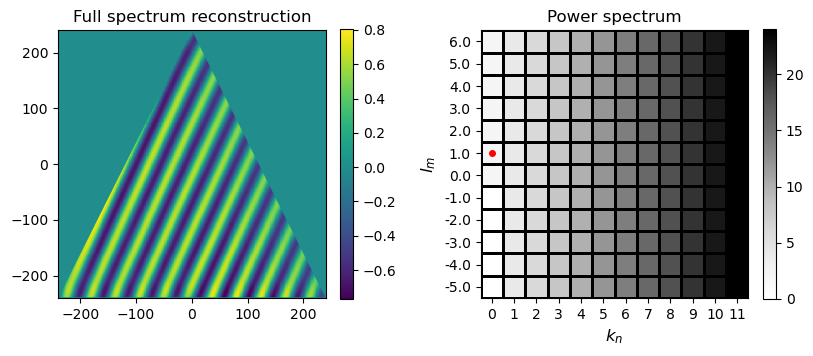

In [209]:


coarse_lmbdas = np.zeros((nhi,nhj,len(cl_range)))
# coarse_lmbdas = np.zeros((nhi*nhj,len(cl_range)))
# fine_lmbdas = np.zeros_like((nhi,nhj,len(fl_range)))

coarse_lmbdas_errs = np.zeros_like(coarse_lmbdas)
fine_lmbdas_errs = np.zeros_like(fine_lmbdas)

cnt = 0
for li,ln in enumerate(ll):
    cnt += 1
    for ki,kn in enumerate(kk):
        # print(kn,ln)
        if ((kn == 0) and (ln < 0)):
            coarse_lmbdas[li,ki,...] = 0.0
            # coarse_lmbdas[cnt,...] = 0.0

        coarse_lmbdas[li,ki,...] = cnt #10.0#np.abs(kn)+np.abs(ln)
        # coarse_lmbdas[cnt,...] = kn+ln
        
        
        
# coarse_lmbdas = coarse_lmbdas.reshape(nhi,nhj,len(cl_range))
coarse_lmbdas = np.transpose(coarse_lmbdas,axes=(1,0,2))
projected = np.zeros((nhi,nhj))

for li,ln in enumerate(ll):
    for ki,kn in enumerate(kk):
        if ((kn == 0) and (ln < 0)):
            continue
            
        projected[li,ki] = coarse_lmbdas[li,ki,0]
        
projected = projected.reshape(nhi,nhj)

fs = (10,5)
fig, axs = plt.subplots(1,2, figsize=fs)
fig_obj = plotter.fig_obj(fig, nhi, nhj)
axs[0] = fig_obj.phys_panel(axs[0], dat_2D)
axs[1] = fig_obj.freq_panel(axs[1], projected)

In [158]:
print(min_cl, min_fl)

0.7 0.72


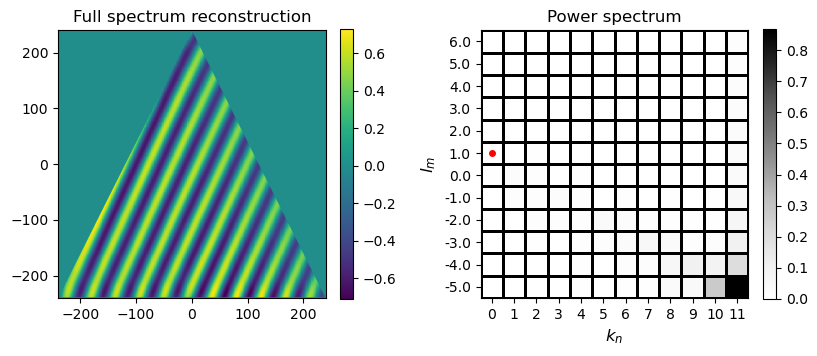

In [134]:
import matplotlib.pyplot as plt

fs = (10,5)
fig, axs = plt.subplots(1,2, figsize=fs)
fig_obj = plotter.fig_obj(fig, nhi, nhj)
axs[0] = fig_obj.phys_panel(axs[0], dat_2D)
axs[1] = fig_obj.freq_panel(axs[1], fobj.ampls)

In [99]:
np.arange(1,21) / 100

array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 ])

In [166]:

ll = np.arange(-5,7)
kk = np.arange(0,12)

for kn in kk:
    for ln in ll:
        if ((kn == 0) and (ln < 0)):
            continue
        
        func = np.sin( kn * cell.lat_grid + ln * cell.lon_grid)
        print(kn, ln)

0 0
0 1
0 2
0 3
0 4
0 5
0 6
1 -5
1 -4
1 -3
1 -2
1 -1
1 0
1 1
1 2
1 3
1 4
1 5
1 6
2 -5
2 -4
2 -3
2 -2
2 -1
2 0
2 1
2 2
2 3
2 4
2 5
2 6
3 -5
3 -4
3 -3
3 -2
3 -1
3 0
3 1
3 2
3 3
3 4
3 5
3 6
4 -5
4 -4
4 -3
4 -2
4 -1
4 0
4 1
4 2
4 3
4 4
4 5
4 6
5 -5
5 -4
5 -3
5 -2
5 -1
5 0
5 1
5 2
5 3
5 4
5 5
5 6
6 -5
6 -4
6 -3
6 -2
6 -1
6 0
6 1
6 2
6 3
6 4
6 5
6 6
7 -5
7 -4
7 -3
7 -2
7 -1
7 0
7 1
7 2
7 3
7 4
7 5
7 6
8 -5
8 -4
8 -3
8 -2
8 -1
8 0
8 1
8 2
8 3
8 4
8 5
8 6
9 -5
9 -4
9 -3
9 -2
9 -1
9 0
9 1
9 2
9 3
9 4
9 5
9 6
10 -5
10 -4
10 -3
10 -2
10 -1
10 0
10 1
10 2
10 3
10 4
10 5
10 6
11 -5
11 -4
11 -3
11 -2
11 -1
11 0
11 1
11 2
11 3
11 4
11 5
11 6
